# LSTM

_https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/_

### Setup

In [1]:
# import pandas
import pandas as pd

# import matplotlib
%matplotlib inline
import matplotlib

plt = matplotlib.pyplot
matplotlib.rcParams['figure.figsize'] = [15, 8]

# preprocessing
from sklearn.preprocessing import MinMaxScaler

# models
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

# saving
import pickle

# misc
import numpy as np
from scipy.signal import savgol_filter

# const
LOOKBACK_FRAME = 4 * 12
FORECAST_FRAME = 4 * 24

### Load Observations

                            airtemp  cloudcover  precip  107337_00065  \
2008-01-01 06:15:00+00:00 -7.274530    2.741197     0.0      4.881867   
2008-01-01 06:30:00+00:00 -7.352735    2.464017     0.0      4.879670   
2008-01-01 06:45:00+00:00 -7.365834    2.229257     0.0      4.877545   
2008-01-01 07:00:00+00:00 -7.319631    2.035260     0.0      4.875494   
2008-01-01 07:15:00+00:00 -7.219930    1.880372     0.0      4.873519   

                           107338_00010  
2008-01-01 06:15:00+00:00      1.943590  
2008-01-01 06:30:00+00:00      1.918974  
2008-01-01 06:45:00+00:00      1.895998  
2008-01-01 07:00:00+00:00      1.874504  
2008-01-01 07:15:00+00:00      1.854337  


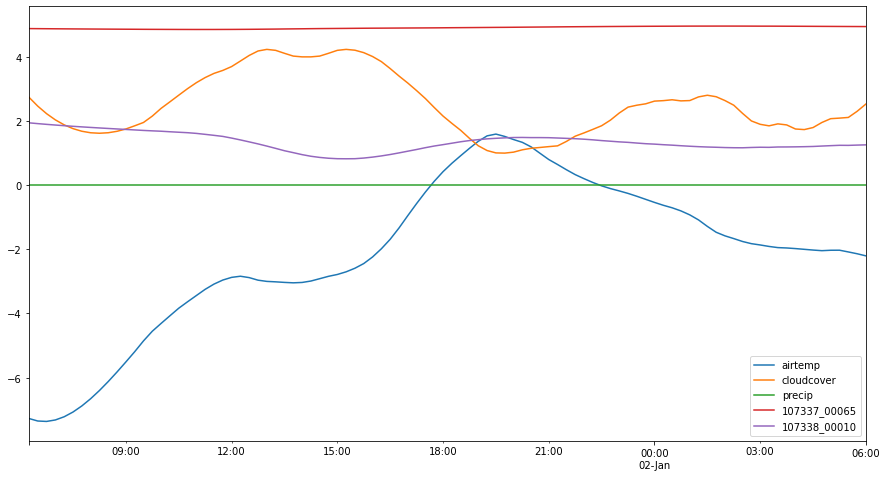

In [2]:
observations = pd.read_pickle('output/observations.pickle')

# to make this data better suited for regression, we'll run it through savitzky golay to smooth
observations = observations.apply(lambda d: savgol_filter(d, 25, 3))

print(observations.head())
observations.head(4 * 24).plot()
plt.show()

### Prepare Dataframe for LSTM

In [3]:
values = observations.values

# ensure values are floats
values = values.astype('float')

# normalize features
in_values = values[:, 0:3]
out_values = values[:, 3:6]
in_scaler = MinMaxScaler(feature_range=(0, 1))
out_scaler = MinMaxScaler(feature_range=(0, 1))
in_scaled = in_scaler.fit_transform(in_values)
out_scaled = out_scaler.fit_transform(out_values)
scaled = pd.DataFrame(np.hstack((in_scaled, out_scaled)))

pickle.dump(in_scaler, open('output/in_scaler.pickle', 'wb'))
pickle.dump(out_scaler, open('output/out_scaler.pickle', 'wb'))

# ! revisit
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def reframe_data(df, lookback, forecast):
	# convert from series to supervised set
	reframed = series_to_supervised(df, lookback, forecast)

	columns = reframed.columns.to_list()
	historical = columns[:5 * lookback + 3]
	projected = []
	predict = []
	for i in range(forecast):
		start_col = 5 * (lookback + 1)
		batch = columns[start_col + (i * 5):start_col + ((i + 1) * 5)]
		projected += batch[:3]
		predict += batch[3:]

	return reframed[historical + projected + columns[5 * lookback + 3:5 * (lookback + 1)] + predict]

reframed = reframe_data(scaled, LOOKBACK_FRAME, FORECAST_FRAME)
print(reframed.head())

    var1(t-48)  var2(t-48)  var3(t-48)  var4(t-48)  var5(t-48)  var1(t-47)  \
48    0.221108    0.568749    0.099144    0.182968    0.073764    0.220149   
49    0.220149    0.521716    0.099144    0.182778    0.072960    0.219989   
50    0.219989    0.481881    0.099144    0.182595    0.072210    0.220555   
51    0.220555    0.448963    0.099144    0.182417    0.071508    0.221777   
52    0.221777    0.422681    0.099144    0.182247    0.070849    0.223584   

    var2(t-47)  var3(t-47)  var4(t-47)  var5(t-47)  ...  var4(t+91)  \
48    0.521716    0.099144    0.182778    0.072960  ...    0.184402   
49    0.481881    0.099144    0.182595    0.072210  ...    0.184312   
50    0.448963    0.099144    0.182417    0.071508  ...    0.184175   
51    0.422681    0.099144    0.182247    0.070849  ...    0.184040   
52    0.402754    0.099144    0.182082    0.070229  ...    0.183910   

    var5(t+91)  var4(t+92)  var5(t+92)  var4(t+93)  var5(t+93)  var4(t+94)  \
48    0.052408    0.184312

### Split Train/Test

In [4]:
values = reframed.values
train_portion = 0.8 # 80%
divider = int(len(values) * train_portion)

train = values[:divider, :]
test = values[divider:, :]

train_X, train_y = train[:, :-(2 * FORECAST_FRAME)], train[:, -(2 * FORECAST_FRAME):]
test_X, test_y = test[:, :-(2 * FORECAST_FRAME)], test[:, -(2 * FORECAST_FRAME):]

# reshape
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(390109, 1, 528) (390109, 192) (97528, 1, 528) (97528, 192)


### Create Model

In [10]:
train = pd.DataFrame()
test = pd.DataFrame()

batch_size = 4 * 24 * 365 # process one year at a time to capture annual seasonality

for i in range(1):
  # define model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(500, activation='relu', return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
  # model.add(tf.keras.layers.LSTM(400, activation='relu'))
  model.add(tf.keras.layers.Dense(2 * FORECAST_FRAME))
  model.compile(loss='mse', optimizer='adam')

  # early stopping
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

  # fit
  history = model.fit(train_X,
                      train_y,
                      epochs=100,
                      batch_size=batch_size,
                      validation_data=(test_X, test_y),
                      verbose=2,
                      shuffle=False,
                      callbacks=[callback])
  model.reset_states()

  # record results
  train[str(i)] = history.history['loss']
  test[str(i)] = history.history['val_loss']

# save last model
model.save('output/model.h5')

plt.plot(train, color='blue', label='train')
plt.plot(test, color='orange', label='validation')
plt.legend()
plt.show()

Epoch 1/100


2022-06-26 22:07:02.201613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-26 22:08:30.245993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


813/813 - 95s - loss: 0.0158 - val_loss: 0.0347 - 95s/epoch - 117ms/step
Epoch 2/100


KeyboardInterrupt: 

### Sanity Check

In [ ]:
# get the last three days of data from the dataset (previously used for validation)
test = observations.tail(4 * 36).values
expected = test[:, 3:]

# scale
test = np.hstack((in_scaler.transform(test[:, :3]), out_scaler.transform(test[:, 3:])))

print(test.shape)

predicted = np.array(test[:LOOKBACK_FRAME, 3:])
for i in range(int((test.shape[0] - LOOKBACK_FRAME) / LOOKBACK_FRAME) - 1):
  print('== iter {} => steps {} to {}'.format(i, LOOKBACK_FRAME * i, LOOKBACK_FRAME * (i + 1) + FORECAST_FRAME))

  # reframe data
  test_reframed = reframe_data(pd.DataFrame(test[LOOKBACK_FRAME * i:LOOKBACK_FRAME * (i + 1) + FORECAST_FRAME, :]), LOOKBACK_FRAME, FORECAST_FRAME)

  # prepare input
  test_X = test_reframed.values[:, :-FORECAST_FRAME * 2]
  test_X = test_X.reshape((1, 1, test_X.shape[1]))

  # predict
  pred = model.predict(test_X, verbose=0)
  pred = pred.reshape(96, 2)

  # update data with predicted values
  test[LOOKBACK_FRAME * (i + 1):LOOKBACK_FRAME * (i + 1) + FORECAST_FRAME, 3:] = pred

  # store prediction
  predicted = np.append(predicted, pred, axis=0)

# rescale
predicted = out_scaler.inverse_transform(predicted)

predicted[:, 0] = savgol_filter(predicted[:, 0], 25, 3)
predicted[:, 1] = savgol_filter(predicted[:, 1], 25, 3)

# graph
plt.plot(predicted)
plt.plot(expected)
plt.legend(['forecast gage height', 'forecast water temp', 'actual gage height', 'actual water temp'])
plt.show()